In [1]:
import warnings
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
warnings.filterwarnings('ignore')

## Load data

In [2]:
NUM_CLASSES = 4
CLASSES_TO_KEEP = [0, 1, 2, 3]

In [3]:
data = pd.read_csv('california.csv')
data.target = np.floor(data.target * NUM_CLASSES/5).astype('uint8')
data = data[data.target.apply(lambda x: x in CLASSES_TO_KEEP)]
data.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,3
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,2
2,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,2
3,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,2
4,4.0368,52.0,4.761658,1.103627,413.0,2.139896,37.85,-122.25,2


## Stratify

In [4]:
train, test = train_test_split(data, stratify=data.target, random_state=42)
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

## Normalize

In [5]:
mu = train.loc[:,:'Longitude'].mean()
sigma = train.loc[:,:'Longitude'].std()

train.loc[:,:'Longitude'] = (train.loc[:,:'Longitude'] - mu) / sigma
test.loc[:,:'Longitude'] = (test.loc[:,:'Longitude'] - mu)/sigma

## Verify stratification and priors

In [6]:
priors = pd.DataFrame({
    'train': train.target.value_counts() / len(train),
    'test' : test.target.value_counts() / len(test)
})
priors

,train,test
1,0.475438,0.475565
0,0.272779,0.272794
2,0.197471,0.197423
3,0.054313,0.054218


## Baseline using Gaussian Naive Bayes library

In [7]:
model = GaussianNB().fit(train.loc[:,:'Longitude'], train.target)
preds = model.predict(train.loc[:,:'Longitude'])
print("Train Accuracy: ", (train.target == preds).mean())

preds = model.predict(test.loc[:,:'Longitude'])
print("Test Accuracy: ", (test.target == preds).mean())

Train Accuracy:  0.6070849546044098
Test Accuracy:  0.6029662047167518


## Gaussian Model

In [8]:
class ClassConditionalGaussianModel:
    def __init__(self, prior, mean, covInv, covDet):
        self.prior = prior
        self.mean = mean
        self.covInv = covInv
        self.denominator = np.sqrt(covDet)
        
    def posteriorProbScaled(self, x):
        z = x - self.mean
        numerator = self.prior * np.exp(-0.5 * np.diagonal(z @ self.covInv @ z.T) )
        return numerator/self.denominator

def predict(models, x):
    if type(x) != np.ndarray:
        x = np.array(x)
    return np.array([model.posteriorProbScaled(x) for model in models]).T.argmax(axis=1)

def getModels(train, classes=CLASSES_TO_KEEP):
    X = np.array(train.loc[:,:'Longitude'])
    y = np.array(train.target)
    
    idx = [y==i for i in classes] # X[idx[0]] gives all examples with target class 0
    priors = [j.mean() for j in idx] # priors is fraction of times each class appears in the dataset
    
    means = [ X[j].mean(axis=0) for j in idx ] #classwise means
    
    covs = [ np.cov(X[j], rowvar=False) for j in idx ]
    covInvs = [ np.linalg.inv(c) for c in covs ]
    covDets = [ np.linalg.det(c) for c in covs ]
    
    return [        
        ClassConditionalGaussianModel(priors[i], means[i], covInvs[i], covDets[i])
        for i in classes
    ]

In [9]:
models = getModels(train)

preds = predict(models, train.loc[:,:'Longitude'])
print("Train accuracy: ", (train.target == preds).mean())

preds = predict(models, test.loc[:,:'Longitude'])
print("Test accuracy: ", (test.target == preds).mean())

Train accuracy:  0.6913099870298314
Test accuracy:  0.6851446632628252


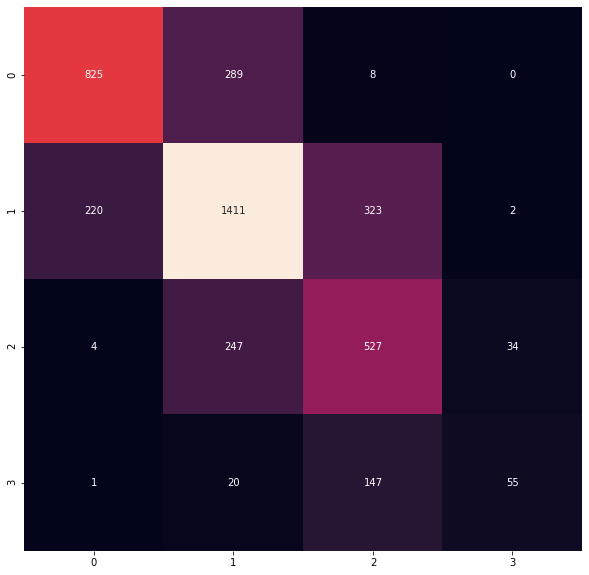

In [10]:
cm = confusion_matrix(test.target, preds)
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='.0f', cbar=False);

In [11]:
for idx, model in enumerate(models):
    print(f"Class={idx}")
    print(model.mean*sigma + mu)
    print()

Class=0
MedInc           2.509050
HouseAge        28.841010
AveRooms         4.933589
AveBedrms        1.059839
Population    1206.956018
AveOccup         2.958886
Latitude        36.517064
Longitude     -119.806496
dtype: float64

Class=1
MedInc           3.666294
HouseAge        28.589940
AveRooms         5.041481
AveBedrms        1.043541
Population    1320.905541
AveOccup         2.899212
Latitude        35.312321
Longitude     -119.398645
dtype: float64

Class=2
MedInc           4.768619
HouseAge        30.418719
AveRooms         5.501702
AveBedrms        1.038264
Population    1253.208949
AveOccup         2.616477
Latitude        35.554688
Longitude     -119.978534
dtype: float64

Class=3
MedInc           5.434312
HouseAge        33.800000
AveRooms         5.657103
AveBedrms        1.038830
Population    1169.725373
AveOccup         2.430750
Latitude        35.469463
Longitude     -119.936119
dtype: float64



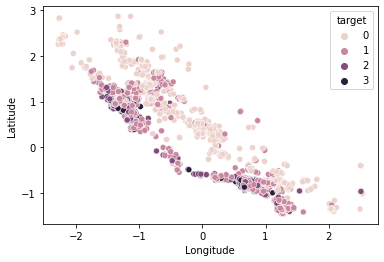

In [12]:
sns.scatterplot(data=test, y='Latitude', x='Longitude', hue='target')